In [35]:
from helper1 import Kuzushiji49Dataset

In [ ]:
import torch
# import dataset
from torchvision.datasets import KMNIST

# import Conv.NN PyTorch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

# import PyTorch data handling functions
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, ToPILImage
from torch.optim import Adam
from torch import nn

# import all other necessary packages
import matplotlib
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import time

In [ ]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the PyTorch 'Module' parent constructor
		super(LeNet, self).__init__()
		# initialize a set of CONV => RELU => POOL layers
		# Convolution layer - 20 filters, 5x5
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize another set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of layers
		# CONV => RELU => MAX POOL
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [ ]:
          # define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# load the KMNISTT dataset
print("[INFO] loading the KMNIST dataset...")
# trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
# testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())

trainData = Kuzushiji49Dataset(data_dir="data", train=True, transform=ToTensor())
testData = Kuzushiji49Dataset(data_dir="data", train=False, transform=ToTensor())


# calculate the train/validation split
print("[INFO] completed loading dataset.")
print("[INFO] generating the train/validation split...")

# Calculate the number of samples for training and validation
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
# Direct calculation of numValSamples to ensure total sum correctness
numValSamples = len(trainData) - numTrainSamples

# Apply random_split correctly
(trainDataSplit, valDataSplit) = random_split(trainData, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(42))

# Initialize the train, validation, and test data loaders
# Note: You should ensure testData is correctly defined before this point
trainDataLoader = DataLoader(trainDataSplit, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataSplit, batch_size=BATCH_SIZE, shuffle=False)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=False)

# Recalculate steps per epoch for training and validation set based on actual split datasets
trainSteps = len(trainDataSplit) // BATCH_SIZE
valSteps = len(valDataSplit) // BATCH_SIZE

print("[INFO] Setup complete.")

[INFO] loading the KMNIST dataset...
[INFO] completed loading dataset.
[INFO] generating the train/validation split...
[INFO] Setup complete.


In [38]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.classes)).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
TRAIN_HISTORY = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

[INFO] initializing the LeNet model...


In [39]:
# Initialize model training
print("[INFO] training the CNN...")

# measure how long training is going to take
startTime = time.time()

# loop over epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	TRAIN_HISTORY["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	TRAIN_HISTORY["train_acc"].append(trainCorrect)
	TRAIN_HISTORY["val_loss"].append(avgValLoss.cpu().detach().numpy())
	TRAIN_HISTORY["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

print("[INFO] Completed training.")

 # finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the CNN...
[INFO] EPOCH: 1/10
Train loss: 0.536884, Train accuracy: 0.8561
Val loss: 0.293800, Val accuracy: 0.9176

[INFO] EPOCH: 2/10
Train loss: 0.207312, Train accuracy: 0.9410
Val loss: 0.212111, Val accuracy: 0.9402

[INFO] EPOCH: 3/10
Train loss: 0.145194, Train accuracy: 0.9584
Val loss: 0.177643, Val accuracy: 0.9513

[INFO] EPOCH: 4/10
Train loss: 0.111795, Train accuracy: 0.9672
Val loss: 0.188212, Val accuracy: 0.9490

[INFO] EPOCH: 5/10
Train loss: 0.087725, Train accuracy: 0.9730
Val loss: 0.191091, Val accuracy: 0.9529

[INFO] EPOCH: 6/10
Train loss: 0.070553, Train accuracy: 0.9781
Val loss: 0.190573, Val accuracy: 0.9531

[INFO] EPOCH: 7/10
Train loss: 0.058527, Train accuracy: 0.9813
Val loss: 0.202740, Val accuracy: 0.9521

[INFO] EPOCH: 8/10
Train loss: 0.049918, Train accuracy: 0.9838
Val loss: 0.203872, Val accuracy: 0.9546

[INFO] EPOCH: 9/10
Train loss: 0.044887, Train accuracy: 0.9853
Val loss: 0.210383, Val accuracy: 0.9546

[INFO] EPOCH: 10/10

In [44]:
# evaluate the network on the test set
print("[INFO] evaluating network...")

# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store predictions
	preds = []
	# Initialize a list to store true labels
	true_labels = []

	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
		true_labels.extend(y.cpu().numpy())
# generate a classification report
print(classification_report(true_labels,
	np.array(preds), target_names=testData.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.94      1000
     Class 1       0.97      0.94      0.96      1000
     Class 2       0.94      0.95      0.95      1000
     Class 3       0.83      0.90      0.86       126
     Class 4       0.94      0.91      0.93      1000
     Class 5       0.89      0.88      0.88      1000
     Class 6       0.94      0.90      0.92      1000
     Class 7       0.86      0.93      0.90      1000
     Class 8       0.82      0.93      0.87       767
     Class 9       0.95      0.90      0.93      1000
    Class 10       0.93      0.95      0.94      1000
    Class 11       0.95      0.90      0.93      1000
    Class 12       0.91      0.89      0.90      1000
    Class 13       0.91      0.87      0.89       678
    Class 14       0.87      0.86      0.86       629
    Class 15       0.95      0.93      0.94      1000
    Class 16       0.98      0.94      0.96       41

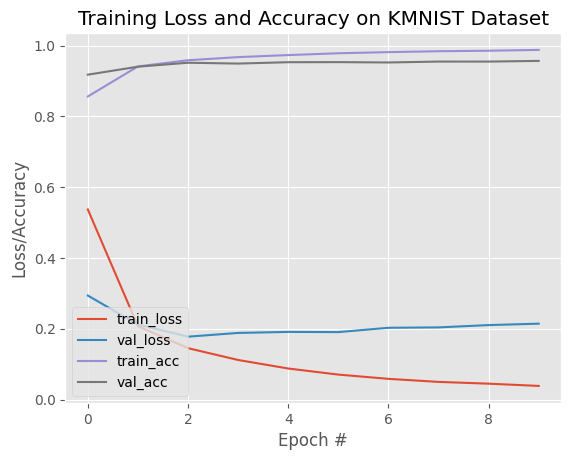

In [45]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(TRAIN_HISTORY["train_loss"], label="train_loss")
plt.plot(TRAIN_HISTORY["val_loss"], label="val_loss")
plt.plot(TRAIN_HISTORY["train_acc"], label="train_acc")
plt.plot(TRAIN_HISTORY["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on KMNIST Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Your existing transformation
transform = ToPILImage()

# Number of images per row and column in the grid
rows = 5
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

for i in range(50):  # Assuming you want to display the first 50 images
    img, label = testData[i]  # Get image and label
    img = transform(img)  # Transform the image

    # Convert PIL image to numpy array for matplotlib
    img_np = np.array(img)

    # Display image
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Hide the axes ticks
    ax.set_title(f'Label: {label}', fontsize=8)  # Optionally set title with label

plt.tight_layout()
plt.show()